<a href="https://colab.research.google.com/github/sakt1moko/Steam-Poster-Factory/blob/main/%5BSTEAM%5D_POSTER_FACTORY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @title ⚙️ 1. INITIALIZE "STEAM POSTER FACTORY V9.1" ENGINE
!pip install wikipedia > /dev/null

import requests
import os
import re
import math
import random
import colorsys
import wikipedia
import pandas as pd
from io import BytesIO
from google.colab import drive
from PIL import Image, ImageFont, ImageDraw, ImageOps, ImageColor, ImageEnhance, ImageFilter, ImageChops
import numpy as np

# --- 0. CONNECTION & API MANAGEMENT ---
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive', force_remount=True)

# YOUR ORIGINAL DRIVE PATH RESTORED
RESOURCES_PATH = "/content/drive/MyDrive/*IA/Colab Notebooks/RECURSOS"

# AUTO-READ API LOGIC
API_FILE = os.path.join(RESOURCES_PATH, "steamgriddb_api.txt")
INTERNAL_API_KEY = "YOUR_API_KEY_HERE"

if os.path.exists(API_FILE):
    try:
        with open(API_FILE, 'r') as f:
            content = f.read().strip()
            if len(content) > 10:
                INTERNAL_API_KEY = content
                print("🔑 API Key loaded automatically.")
            else:
                print("⚠️ API file exists but seems empty.")
    except:
        print("⚠️ Error reading the API file.")
else:
    print("ℹ️ 'steamgriddb_api.txt' not found. Using fallback/manual mode.")

M = 2 # 🚀 HD MULTIPLIER (1200x1800)

# --- 1. FONTS ---
FONT_TITLE_FILE = os.path.join(RESOURCES_PATH, "MotivaSansBlack.woff.ttf")
FONT_BOLD_FILE = os.path.join(RESOURCES_PATH, "MotivaSansExtraBold.ttf")
FALLBACK_FONT = "/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf"

def load_fonts(size_title=66, M=2):
    f_title = ImageFont.truetype(FONT_TITLE_FILE, size_title * M) if os.path.exists(FONT_TITLE_FILE) else ImageFont.truetype(FALLBACK_FONT, size_title * M)
    if os.path.exists(FONT_BOLD_FILE):
        return f_title, ImageFont.truetype(FONT_BOLD_FILE, 26 * M), ImageFont.truetype(FONT_BOLD_FILE, 20 * M), ImageFont.truetype(FONT_BOLD_FILE, 28 * M), ImageFont.truetype(FONT_TITLE_FILE, 19 * M), ImageFont.truetype(FONT_BOLD_FILE, 19 * M)
    else:
        return f_title, ImageFont.truetype(FALLBACK_FONT, 26 * M), ImageFont.truetype(FALLBACK_FONT, 20 * M), ImageFont.truetype(FALLBACK_FONT, 28 * M), ImageFont.truetype(FALLBACK_FONT, 19 * M), ImageFont.truetype(FALLBACK_FONT, 19 * M)

# --- 2. SMART TEXT UTILITIES ---
def wrap_text(draw, text, font, max_width):
    words = text.split()
    lines, current_line, current_w = [], [], 0
    space_w = draw.textlength(" ", font=font)
    for word in words:
        word_w = draw.textlength(word, font=font)
        if current_w + word_w > max_width:
            if current_line: lines.append(current_line)
            current_line = [word]
            current_w = word_w + space_w
        else:
            current_line.append(word)
            current_w += word_w + space_w
    if current_line: lines.append(current_line)
    return lines

def fit_title(draw, text, font_path, max_width, default_size, min_size=60, max_lines=2, M=2):
    font_size = default_size
    while font_size >= min_size:
        font = ImageFont.truetype(font_path, font_size) if os.path.exists(font_path) else ImageFont.truetype(FALLBACK_FONT, font_size)
        lines = wrap_text(draw, text, font, max_width)
        if len(lines) <= max_lines:
            too_wide = False
            for line in lines:
                line_w = sum([draw.textlength(w, font) for w in line]) + draw.textlength(" ", font) * (len(line)-1)
                if line_w > max_width + (10 * M): too_wide = True
            if not too_wide: return font, lines, font_size
        font_size -= (2 * M)
    return font, lines, font_size

# --- 3. GRAPHIC UTILITIES & BRANDS ---
CONSOLE_MAP = {
    'SWITCH': 'NINTENDO', 'WII': 'NINTENDO', 'GAMECUBE': 'NINTENDO', 'N64': 'NINTENDO', 'SNES': 'NINTENDO', 'NINTENDO': 'NINTENDO',
    'PS5': 'PLAYSTATION', 'PS4': 'PLAYSTATION', 'PS3': 'PLAYSTATION', 'PS2': 'PLAYSTATION', 'PSP': 'PLAYSTATION', 'VITA': 'PLAYSTATION', 'PLAYSTATION': 'PLAYSTATION', 'SONY': 'PLAYSTATION',
    'XBOX': 'XBOX', 'SERIES X': 'XBOX', 'SERIES S': 'XBOX',
    'STEAM': 'STEAM', 'PC': 'STEAM', 'EPIC': 'EPIC',
    'DREAMCAST': 'SEGA', 'GENESIS': 'SEGA', 'SEGA': 'SEGA'
}
BRAND_COLORS = {'NINTENDO': '#E60012', 'PLAYSTATION': '#003791', 'XBOX': '#107C10', 'STEAM': '#171a21', 'SEGA': '#0089CF', 'GENERIC': '#333333'}

def get_brand_info(platform_raw):
    plat_upper = platform_raw.upper().strip()
    brand_key = "GENERIC"
    for key, brand in CONSOLE_MAP.items():
        if key in plat_upper: brand_key = brand; break
    if brand_key == "GENERIC":
        if "PLAYSTATION" in plat_upper or "SONY" in plat_upper: brand_key = "PLAYSTATION"
        elif "NINTENDO" in plat_upper: brand_key = "NINTENDO"
        elif "XBOX" in plat_upper: brand_key = "XBOX"
    return brand_key, BRAND_COLORS.get(brand_key, BRAND_COLORS['GENERIC']), plat_upper

def round_corners(image, radius):
    if radius <= 0: return image
    image = image.convert("RGBA")
    factor = 4
    rad_hr = radius * factor
    circle_hr = Image.new('L', (rad_hr * 2, rad_hr * 2), 0)
    draw_hr = ImageDraw.Draw(circle_hr)
    draw_hr.ellipse((0, 0, rad_hr * 2, rad_hr * 2), fill=255)
    circle = circle_hr.resize((radius * 2, radius * 2), Image.LANCZOS)

    alpha = Image.new('L', image.size, 255)
    w, h = image.size
    for crop_args, paste_pos in [
        ((0, 0, radius, radius), (0, 0)), ((0, radius, radius, radius * 2), (0, h - radius)),
        ((radius, 0, radius * 2, radius), (w - radius, 0)), ((radius, radius, radius * 2, radius * 2), (w - radius, h - radius))
    ]: alpha.paste(circle.crop(crop_args), paste_pos)

    image.putalpha(alpha)
    return image

def paste_with_alpha(bg, fg, box):
    if fg.mode == 'RGBA': bg.paste(fg, box, fg)
    else: bg.paste(fg, box)

def apply_texture(image, texture_type, M=2):
    W, H = image.size
    if texture_type == "Paper":
        tint = Image.new("RGBA", (W, H), (250, 245, 230, 20))
        noise = Image.new("RGBA", (W, H))
        pixels = noise.load()
        for y in range(0, H, 2 * M):
            for x in range(0, W, 2 * M):
                if random.random() > 0.3: pixels[x, y] = (150, 140, 100, 15)
        return Image.alpha_composite(Image.alpha_composite(image.convert("RGBA"), tint), noise).convert("RGB")
    elif texture_type == "Noise":
        noise_rgba = Image.new("RGBA", (W, H))
        pixels = noise_rgba.load()
        for y in range(H):
            for x in range(W):
                if random.random() > 0.7: pixels[x, y] = (0, 0, 0, 25)
        return Image.alpha_composite(image.convert("RGBA"), noise_rgba).convert("RGB")
    elif texture_type == "Vignette":
        Y, X = np.ogrid[:H, :W]
        mask = np.clip((np.sqrt((X - W/2)**2 + (Y-H/2)**2) / math.sqrt((W/2)**2 + (H/2)**2)) * 255, 0, 255).astype(np.uint8)
        vignette = Image.new("RGB", (W, H), (0, 0, 0))
        vignette.putalpha(Image.fromarray((mask * 0.4).astype(np.uint8)))
        return Image.alpha_composite(image.convert("RGBA"), vignette).convert("RGB")
    return image

def make_silhouette(image, color_rgb):
    image = image.convert("RGBA")
    solid = Image.new("RGB", image.size, color_rgb)
    final = Image.new("RGBA", image.size)
    final.paste(solid, (0,0), mask=image.split()[3])
    return final

def dampen_color(rgb_tuple):
    h, s, v = colorsys.rgb_to_hsv(rgb_tuple[0]/255.0, rgb_tuple[1]/255.0, rgb_tuple[2]/255.0)
    if v > 0.8: v *= 0.75
    if s > 0.8: s *= 0.85
    nr, ng, nb = colorsys.hsv_to_rgb(h, s, v)
    return (int(nr*255), int(ng*255), int(nb*255))

def get_smart_palette(image, count=4):
    pixels = list(image.convert("RGB").resize((100, 100)).getdata())
    scored_colors, seen_colors = [], set()
    for r, g, b in pixels:
        r_s, g_s, b_s = (r//20)*20, (g//20)*20, (b//20)*20
        if (r_s, g_s, b_s) in seen_colors: continue
        h, s, v = colorsys.rgb_to_hsv(r/255, g/255, b/255)
        score = s * v * 10 - (20 if v > 0.9 else 0) - (50 if v < 0.15 else 0)
        seen_colors.add((r_s, g_s, b_s))
        scored_colors.append({'rgb': (r, g, b), 'score': score})
    scored_colors.sort(key=lambda x: x['score'], reverse=True)
    final_palette = []
    for item in scored_colors:
        c = dampen_color(item['rgb'])
        if all(math.sqrt(sum((a - b)**2 for a, b in zip(c, chosen))) >= 60 for chosen in final_palette):
            final_palette.append(c)
        if len(final_palette) >= count: break
    while len(final_palette) < count: final_palette.append((50, 50, 50))
    return final_palette

# 🚀 BULLETPROOF DOWNLOAD FUNCTION
def download_image(url):
    if not url: return None
    try:
        img = Image.open(BytesIO(requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}, timeout=5).content))
        # Convert ALWAYS to RGBA to kill 'P' (Palette) format and prevent filter crashes
        return img.convert("RGBA")
    except Exception as e:
        print(f"⚠️ Failed to download image {url}: {e}")
        return None

def fetch_game_data(name):
    data = {'title': name, 'dev': 'Unknown', 'year': '????', 'plat': 'PC', 'genres': [], 'logo_url': None, 'header_url': None, 'poster_url': None, 'poster_url_clean': None, 'steam_bg_raw': None, 'sgdb_hero_clean': None}
    app_id_found = None
    try:
        r = requests.get("https://store.steampowered.com/api/storesearch", params={'term': name, 'l': 'english', 'cc': 'US'}).json()
        if r['total'] > 0:
            app_id_found = r['items'][0]['id']
            info = requests.get("https://store.steampowered.com/api/appdetails", params={'appids': app_id_found}).json()[str(app_id_found)]['data']

            data['steam_bg_raw'] = f"https://cdn.akamai.steamstatic.com/steam/apps/{app_id_found}/page_bg_raw.jpg"

            data.update({
                'title': info['name'], 'dev': info.get('developers', ['Unknown'])[0],
                'year': info.get('release_date', {}).get('date', '????').split(',')[-1].strip(),
                'genres': [g['description'].upper() for g in info.get('genres', [])[:3]],
                'header_url': info.get('header_image'),
                'logo_url': f"https://cdn.akamai.steamstatic.com/steam/apps/{app_id_found}/logo.png",
                'poster_url': f"https://steamcdn-a.akamaihd.net/steam/apps/{app_id_found}/library_600x900_2x.jpg"
            })
    except: pass

    if app_id_found:
        try:
            steamspy_r = requests.get(f"https://steamspy.com/api.php?request=appdetails&appid={app_id_found}").json()
            if 'tags' in steamspy_r and isinstance(steamspy_r['tags'], dict):
                sorted_tags = sorted(steamspy_r['tags'].items(), key=lambda x: x[1], reverse=True)
                ignore_tags = {'Singleplayer', 'Multiplayer', 'Co-op', 'Great Soundtrack', 'Story Rich', 'Atmospheric', '2D', '3D', 'Indie', 'Action-Adventure', 'Early Access', 'Steam Achievements'}
                best_tags = [t[0].upper() for t in sorted_tags if t[0] not in ignore_tags][:3]
                if best_tags: data['genres'] = best_tags
        except: pass

    if data['year'] == '????':
        try:
            wikipedia.set_lang("en")
            page = wikipedia.page(f"{name} (video game)", auto_suggest=True)
            match_year = re.search(r"\b(19\d{2}|20\d{2})\b", page.summary[:500])
            if match_year: data['year'] = match_year.group(1)
            data['title'] = page.title.replace("(video game)", "").strip()
        except: pass

    try:
        if INTERNAL_API_KEY != "YOUR_API_KEY_HERE":
            headers = {'Authorization': f'Bearer {INTERNAL_API_KEY}'}
            sgdb_search = requests.get(f"https://www.steamgriddb.com/api/v2/search/autocomplete/{name}", headers=headers).json()
            if sgdb_search['data']:
                game_id = sgdb_search['data'][0]['id']

                # Logos
                r_logo = requests.get(f"https://www.steamgriddb.com/api/v2/logos/game/{game_id}", headers=headers).json()
                if r_logo['data']: data['logo_url'] = r_logo['data'][0]['url']

                # Grids (Vertical Posters)
                r_grid = requests.get(f"https://www.steamgriddb.com/api/v2/grids/game/{game_id}?styles=no_logo", headers=headers).json()
                if r_grid['data']:
                    data['poster_url_clean'] = r_grid['data'][0]['url']
                else:
                    r_grid_any = requests.get(f"https://www.steamgriddb.com/api/v2/grids/game/{game_id}", headers=headers).json()
                    if r_grid_any['data']: data['poster_url_clean'] = r_grid_any['data'][0]['url']

                # Heroes (Horizontal Banners)
                r_hero = requests.get(f"https://www.steamgriddb.com/api/v2/heroes/game/{game_id}?styles=no_logo", headers=headers).json()
                if r_hero['data']:
                    data['sgdb_hero_clean'] = r_hero['data'][0]['url']
                else:
                    r_hero_any = requests.get(f"https://www.steamgriddb.com/api/v2/heroes/game/{game_id}", headers=headers).json()
                    if r_hero_any['data']: data['sgdb_hero_clean'] = r_hero_any['data'][0]['url']

    except: pass
    return data

def show_mini_palette(palette):
    w, h = 600, 20
    pal_img = Image.new("RGB", (w, h))
    draw = ImageDraw.Draw(pal_img)
    step = w // len(palette)
    for i, c in enumerate(palette): draw.rectangle([i*step, 0, (i+1)*step, h], fill=c)
    display(pal_img)

def get_theme_colors(config):
    theme = config.get('bg_color', "Off-White")
    if theme == "Pure White": return "#FFFFFF", "#000000", "#444444"
    if theme == "Black": return "#151515", "#EEEEEE", "#AAAAAA"
    if theme == "Gray": return "#808080", "#FFFFFF", "#DDDDDD"
    return "#D9D9D9", "#222222", "#555555" # Off-White

def get_main_color(config, palette):
    if "Black" in config['color_selection']: return (25, 25, 25)
    color_idx = 0
    if "Secondary" in config['color_selection']: color_idx = 1
    elif "Tertiary" in config['color_selection']: color_idx = 2
    elif "Quaternary" in config['color_selection']: color_idx = 3
    box_color = palette[color_idx]
    if "Custom" in config['color_selection'] and config['custom_hex']:
        try: box_color = ImageColor.getrgb(config['custom_hex'].strip())
        except: pass
    return box_color

def draw_genres(draw, genres, target_y, cursor_x, max_x, f_text, f_sep, text_color, M=2):
    valid_genres = []
    current_x = cursor_x
    for g in genres[:3]:
        g_width = draw.textlength(g, font=f_text)
        sep_width = 0
        if valid_genres:
            sep_width = 20 * M + draw.textlength("|", font=f_sep)
        if not valid_genres or (current_x + sep_width + g_width <= max_x):
            valid_genres.append(g)
            current_x += (sep_width + g_width)
        else:
            break

    temp_x = cursor_x
    for i, g in enumerate(valid_genres):
        draw.text((temp_x, target_y), g, font=f_text, fill=text_color, anchor="lm")
        temp_x += draw.textlength(g, font=f_text)
        if i < len(valid_genres) - 1:
            draw.text((temp_x + 10 * M, target_y - 2 * M), "|", font=f_sep, fill=text_color, anchor="lm")
            temp_x += 20 * M + draw.textlength("|", font=f_sep)

def get_centering(config):
    ax = config.get('align_x', 'Center')
    ay = config.get('align_y', 'Center')

    cx = 0.0 if ax == "Left" else (1.0 if ax == "Right" else 0.5)
    cy = 0.0 if ay == "Top" else (1.0 if ay == "Bottom" else 0.5)
    return (cx, cy)

def get_best_image(data, config):
    if config.get('img_url'):
        img = download_image(config['img_url'])
        if img: return img

    source = config.get('image_source', "SteamGridDB (No Logo)")

    options = []
    if source == "SteamGridDB (No Logo)":
        options = [data.get('poster_url_clean'), data.get('steam_bg_raw'), data.get('sgdb_hero_clean'), data.get('poster_url')]
    elif source == "Steam Banner (Clean Background)":
        options = [data.get('steam_bg_raw'), data.get('sgdb_hero_clean'), data.get('header_url'), data.get('poster_url_clean')]
    else:
        options = [data.get('poster_url'), data.get('poster_url_clean'), data.get('steam_bg_raw')]

    for op in options:
        if op:
            img = download_image(op)
            if img: return img
    return None

# --- 5. RENDER ENGINES HD ---

def render_box_poster(data, config, palette):
    f_title, f_year, f_dev, _, f_genre_text, f_genre_sep = load_fonts(66, M)
    bg_hex, text_main, text_sec = get_theme_colors(config)
    canvas = Image.new("RGB", (600 * M, 900 * M), bg_hex)
    draw = ImageDraw.Draw(canvas)
    main_color = get_main_color(config, palette)
    if "Black" in config['color_selection']: main_color = palette[0]

    col_year = main_color if config.get('color_data') else text_main
    col_dev = main_color if config.get('color_data') else text_sec
    col_gen = main_color if config.get('color_genres') else text_sec

    for i in range(4): draw.rectangle([30*M + (i * 62*M), 25*M, 90*M + (i * 62*M), 37*M], fill=palette[i % len(palette)])
    draw.text((570*M, 20*M), str(data['year']), font=f_year, fill=col_year, anchor="rt")
    draw.text((570*M, 52*M), data['dev'], font=f_dev, fill=col_dev, anchor="rt")

    img = get_best_image(data, config)
    if img:
        img_fit = ImageOps.fit(img, (540*M, 550*M), method=Image.LANCZOS, centering=get_centering(config))
        img_fit = ImageEnhance.Sharpness(img_fit).enhance(1.3)
        try: border_rad = int(config['border_radius']) * M
        except: border_rad = 0
        img_rc = round_corners(img_fit, border_rad)
        paste_with_alpha(canvas, img_rc, (30*M, 100*M))

    draw_genres(draw, data['genres'], 670*M, 30*M, 570*M, f_genre_text, f_genre_sep, col_gen, M)

    f_title_dynamic, lines_to_draw, used_size = fit_title(draw, data['title'], FONT_TITLE_FILE, 540*M, 66*M, min_size=30*M, M=M)
    space_width = draw.textlength(" ", font=f_title_dynamic)

    color_idx, current_y = 0, 685*M

    for line_words in lines_to_draw:
        line_width = sum(draw.textlength(w, font=f_title_dynamic) for w in line_words) + space_width * (len(line_words) - 1)
        cursor_x = 570*M - line_width
        for word in line_words:
            draw.text((cursor_x, current_y), word, font=f_title_dynamic, fill=palette[color_idx % len(palette)], anchor="la")
            cursor_x += draw.textlength(word, font=f_title_dynamic) + space_width
            color_idx += 1
        current_y += (used_size * 1.15)

    brand_key, brand_color_hex, _ = get_brand_info(data['plat'])
    brand_color_rgb = ImageColor.getrgb(brand_color_hex)

    possible_names = [f"{brand_key} LOGO.png", f"{brand_key}.png"]
    logo_plat_img = None
    for pname in possible_names:
        ppath = os.path.join(RESOURCES_PATH, pname)
        if os.path.exists(ppath):
            logo_plat_img = Image.open(ppath).convert("RGBA")
            break

    if logo_plat_img:
        logo_plat = make_silhouette(logo_plat_img, brand_color_rgb)
        logo_plat = ImageOps.contain(logo_plat, (150*M, 45*M), method=Image.LANCZOS)
        paste_with_alpha(canvas, logo_plat, (30*M, 880*M - logo_plat.height))

    return canvas

def render_logo_box(data, config, palette):
    f_title, f_year, f_dev, f_plat, f_genre_text, f_genre_sep = load_fonts(60, M)
    bg_hex, text_main, text_sec = get_theme_colors(config)
    canvas = Image.new("RGB", (600 * M, 900 * M), bg_hex)
    draw = ImageDraw.Draw(canvas)
    brand_key, footer_color, console_text = get_brand_info(data['plat'])
    main_color = get_main_color(config, palette)
    if "Black" in config['color_selection']: main_color = palette[0]

    col_year = main_color if config.get('color_data') else text_main
    col_dev = main_color if config.get('color_data') else text_sec

    draw.rectangle([30*M, 30*M, 110*M, 42*M], fill=footer_color)
    draw.rectangle([112*M, 30*M, 192*M, 42*M], fill=main_color)
    draw.text((570*M, 25*M), str(data['year']), font=f_year, fill=col_year, anchor="rt")
    draw.text((570*M, 57*M), data['dev'], font=f_dev, fill=col_dev, anchor="rt")

    current_y = 110*M
    f_title_dynamic, lines, used_size = fit_title(draw, data['title'], FONT_TITLE_FILE, 540*M, 60*M, min_size=30*M, M=M)
    for line in lines:
        draw.text((30*M, current_y), " ".join(line), font=f_title_dynamic, fill=text_main, anchor="la")
        current_y += (used_size + 10*M)

    box_y = 260*M
    base_box = Image.new("RGBA", (500*M, 500*M), main_color)
    try: border_rad = int(config['border_radius']) * M
    except: border_rad = 0
    box_rc = round_corners(base_box, border_rad)
    paste_with_alpha(canvas, box_rc, (50*M, box_y))

    logo_img = download_image(config['logo_url_manual'] or config['img_url'] or data['logo_url'])
    if logo_img:
        logo_final = ImageOps.contain(logo_img, (440*M, 440*M), method=Image.LANCZOS)
        paste_x = 50*M + (500*M - logo_final.width) // 2
        paste_y = box_y + (500*M - logo_final.height) // 2
        paste_with_alpha(canvas, logo_final, (paste_x, paste_y))

    draw.rectangle([0, 820*M, 600*M, 870*M], fill=footer_color)
    local_icon_path = os.path.join(RESOURCES_PATH, f"{brand_key}.png")
    center_y = 820*M + (870*M - 820*M) // 2
    if os.path.exists(local_icon_path):
        icon_img = Image.open(local_icon_path).convert("RGBA")
        icon_img = ImageOps.contain(make_silhouette(icon_img, (255, 255, 255)), (160*M, 35*M), method=Image.LANCZOS)
        if brand_key == 'STEAM':
            start_x = (600*M - icon_img.width) // 2
            paste_with_alpha(canvas, icon_img, (start_x, center_y - icon_img.height//2))
        else:
            text_w = draw.textlength(console_text, font=f_plat)
            total_w = icon_img.width + 15*M + text_w
            start_x = (600*M - total_w) // 2
            paste_with_alpha(canvas, icon_img, (start_x, center_y - icon_img.height//2))
            draw.text((start_x + icon_img.width + 15*M, center_y - 2*M), console_text, font=f_plat, fill="#FFFFFF", anchor="lm")
    else:
        draw.text((300*M, center_y), console_text, font=f_plat, fill="#FFFFFF", anchor="mm")

    return canvas

def render_vertical_poster(data, config, palette):
    f_title, f_year, f_dev, f_plat, f_genre_text, f_genre_sep = load_fonts(60, M)
    bg_hex, text_main, text_sec = get_theme_colors(config)
    canvas = Image.new("RGB", (600 * M, 900 * M), bg_hex)
    draw = ImageDraw.Draw(canvas)
    main_color = get_main_color(config, palette)

    col_data_top = main_color if config.get('color_data') else text_sec
    col_gen = main_color if config.get('color_genres') else text_sec

    box_x, box_y = 30*M, 70*M
    img_w, img_h = 430*M, 770*M

    spine_x = box_x + img_w
    spine_w = 125 * M

    brand_key, brand_color_hex, _ = get_brand_info(data['plat'])
    brand_color_rgb = ImageColor.getrgb(brand_color_hex)
    local_icon_path = os.path.join(RESOURCES_PATH, f"{brand_key} LOGO.png")
    if os.path.exists(local_icon_path):
        icon_img = Image.open(local_icon_path).convert("RGBA")
        icon_img = make_silhouette(icon_img, brand_color_rgb)
        icon_fit = ImageOps.contain(icon_img, (115*M, 50*M), method=Image.LANCZOS)
        paste_x = spine_x + (spine_w - icon_fit.width) // 2
        paste_with_alpha(canvas, icon_fit, (paste_x, box_y))

    info_text = f"{data['year']}  |  {data['dev'].upper()}"
    draw.text((box_x, box_y - 12*M), info_text, font=f_dev, fill=col_data_top, anchor="ld")

    img = get_best_image(data, config)
    if img:
        img_fit = ImageOps.fit(img, (img_w, img_h), method=Image.LANCZOS, centering=get_centering(config))
        try: border_rad = int(config['border_radius']) * M
        except: border_rad = 0
        final_rad = border_rad if border_rad > 0 else 15*M
        img_rc = round_corners(img_fit, final_rad)
        paste_with_alpha(canvas, img_rc, (box_x, box_y))

    meta_y = box_y + img_h + 18*M
    draw_genres(draw, data['genres'], meta_y, box_x, box_x + img_w, f_genre_text, f_genre_sep, col_gen, M)

    logo_img = download_image(config['logo_url_manual'] or data['logo_url'])
    if logo_img:
        is_light_bg = bg_hex in ["#FFFFFF", "#D9D9D9", "#808080", "Off-White", "Pure White", "Gray"]
        logo_color = (20, 20, 20) if is_light_bg else (240, 240, 240)

        if config['logo_style'] == "White": logo_color = (255, 255, 255)
        elif config['logo_style'] == "Black": logo_color = (15, 15, 15)

        if config['logo_style'] != "Original":
            logo_final = make_silhouette(logo_img, logo_color)
        else:
            logo_final = logo_img

        logo_area_w = 115*M
        logo_area_h = 600*M
        logo_x = box_x + img_w + 10*M

        logo_fit = ImageOps.contain(logo_final, (logo_area_h, logo_area_w), method=Image.LANCZOS)
        logo_rotated = logo_fit.rotate(90, expand=True, resample=Image.BICUBIC)
        paste_x = logo_x + (logo_area_w - logo_rotated.width) // 2
        paste_y = box_y + img_h - logo_rotated.height
        paste_with_alpha(canvas, logo_rotated, (paste_x, paste_y))

    return canvas

def render_horizontal_poster(data, config, palette):
    W, H = 600 * M, 900 * M
    bg_hex, _, _ = get_theme_colors(config)

    canvas_base = Image.new("RGB", (W, H), bg_hex)

    img_height = int(H * 0.8)

    img = get_best_image(data, config)
    if img:
        img_fit = ImageOps.fit(img, (W, img_height), method=Image.LANCZOS, centering=get_centering(config))
        img_fit = ImageEnhance.Sharpness(img_fit).enhance(1.3)
        canvas_base.paste(img_fit, (0, 0))

    logo_img = download_image(config['logo_url_manual'] or data['logo_url'])
    if logo_img:
        is_light_bg = bg_hex in ["#FFFFFF", "#D9D9D9", "#808080", "Off-White", "Pure White", "Gray"]
        logo_color = (20, 20, 20) if is_light_bg else (240, 240, 240)

        if config['logo_style'] == "White": logo_color = (255, 255, 255)
        elif config['logo_style'] == "Black": logo_color = (15, 15, 15)

        if config['logo_style'] != "Original":
            logo_final = make_silhouette(logo_img, logo_color)
        else:
            logo_final = logo_img

        footer_h = H - img_height
        safe_h = int(footer_h * 0.7)
        safe_w = int(W * 0.85)

        logo_fit = ImageOps.contain(logo_final, (safe_w, safe_h), method=Image.LANCZOS)

        paste_x = (W - logo_fit.width) // 2
        paste_y = img_height + (footer_h - logo_fit.height) // 2

        paste_with_alpha(canvas_base, logo_fit, (paste_x, paste_y))

    return canvas_base

# MAIN ORCHESTRATOR
def generate_poster(name_input, style, manual_data, visual_config, ignore_manual):
    if ignore_manual: manual_data = {k: "" for k in manual_data}
    data = fetch_game_data(name_input)

    for k in ['title', 'dev', 'year', 'plat']:
        if manual_data.get(k): data[k] = manual_data[k]
    if manual_data.get('genres_manual'): data['genres'] = [g.strip().upper() for g in manual_data['genres_manual'].split(',')]

    img_base = get_best_image(data, visual_config)
    palette = get_smart_palette(img_base, 4) if img_base else [(50,50,50)]*4

    print("🎨 Base Palette Extracted (Color 1 | Color 2 | Color 3 | Color 4):")
    show_mini_palette(palette)

    if style == "Box Poster": canvas = render_box_poster(data, visual_config, palette)
    elif style == "Vertical Poster": canvas = render_vertical_poster(data, visual_config, palette)
    elif style == "Horizontal Poster": canvas = render_horizontal_poster(data, visual_config, palette)
    elif style == "Logo Box": canvas = render_logo_box(data, visual_config, palette)

    canvas = apply_texture(canvas, visual_config['texture'], M=M)

    preview = canvas.resize((600, 900), Image.LANCZOS)
    display(preview)
    return canvas, data['title']

print("✅ Steam Poster Factory V9.1 (International Open Source Edition Ready)")

🔑 API Key loaded automatically.
✅ Steam Poster Factory V9.1 (International Open Source Edition Ready)


🎨 Base Palette Extracted (Color 1 | Color 2 | Color 3 | Color 4):


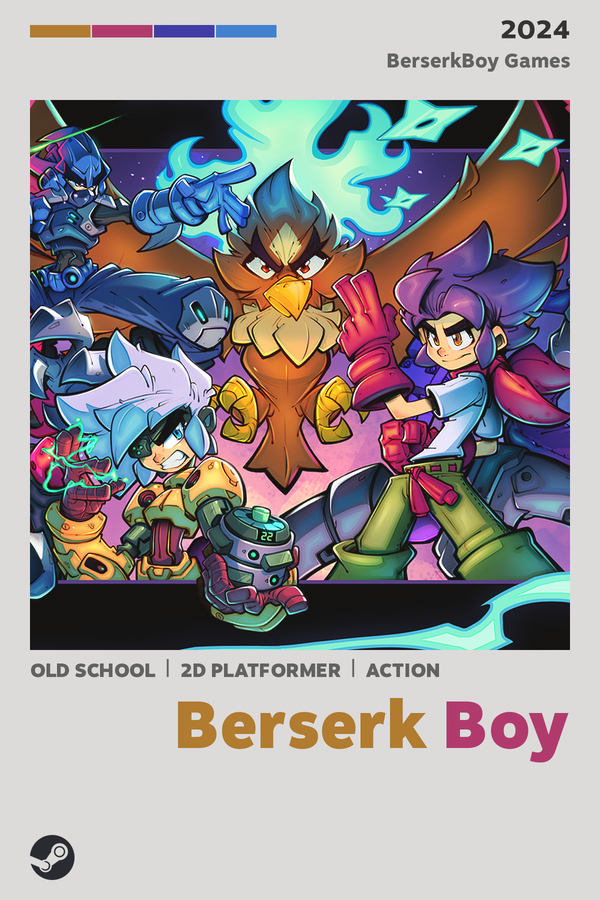

📥 Downloading HD version: Berserk Boy_BoxPoster_v1.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# @title 🎮 STEAM POSTER GENERATOR UI
import os
from google.colab import files

# @markdown ### 🚀 1. SEARCH & STYLE
Game = "berserk boy" # @param {type:"string"}
Style = "Box Poster" # @param ["Box Poster", "Vertical Poster", "Horizontal Poster", "Logo Box"]
Image_Source = "Steam Banner (Clean Background)" # @param ["SteamGridDB (No Logo)", "Steam Banner (Clean Background)", "Steam Poster (With Logo)"]
Align_X = "Center" # @param ["Left", "Center", "Right"]
Align_Y = "Center" # @param ["Top", "Center", "Bottom"]
Ignore_Manual_Data = False # @param {type:"boolean"}

# @markdown ---
# @markdown ### 🎨 2. AESTHETICS
Background_Color = "Off-White" # @param ["Off-White", "Pure White", "Black", "Gray"]
Base_Color = "Black (Default)" # @param ["Black (Default)", "Primary (Color 1)", "Secondary (Color 2)", "Tertiary (Color 3)", "Quaternary (Color 4)", "Custom (Hex)"]
Custom_Hex_Color = "" # @param {type:"string"}
Texture = "Paper" # @param ["None", "Noise", "Vignette", "Paper"]
Image_Border_Radius = 0 # @param [0, 5, 10, 15, 20, 40]

# @markdown ---
# @markdown ### ✨ 3. COLORS
Logo_Color = "Auto" # @param ["Original", "White", "Black", "Auto"]
Color_Year_Developer = False # @param {type:"boolean"}
Color_Genres = False # @param {type:"boolean"}

# @markdown ---
# @markdown ### ✏️ 4. MANUAL OVERRIDES
Title = "" # @param {type:"string"}
Year = "" # @param {type:"string"}
Developer = "" # @param {type:"string"}
Platform = "STEAM" # @param {type:"string"}
Genres = "" # @param {type:"string"}
Image_URL = "" # @param {type:"string"}
Logo_URL = "" # @param {type:"string"}

manual_data = {
    'title': Title, 'dev': Developer,
    'year': Year, 'plat': Platform, 'genres_manual': Genres
}

visual_config = {
    'image_source': Image_Source,
    'bg_color': Background_Color,
    'color_selection': Base_Color, 'custom_hex': Custom_Hex_Color,
    'color_data': Color_Year_Developer, 'color_genres': Color_Genres,
    'align_x': Align_X, 'align_y': Align_Y,
    'logo_style': Logo_Color,
    'img_url': Image_URL, 'logo_url_manual': Logo_URL,
    'border_radius': Image_Border_Radius, 'texture': Texture
}

result, clean_title = generate_poster(Game, Style, manual_data, visual_config, Ignore_Manual_Data)

if result:
    safe_name = clean_title.replace(":", "").replace("/", "-").replace("\\", "").strip()
    prefix = Style.replace(" ", "")
    ver = 1
    while os.path.exists(f"{safe_name}_{prefix}_v{ver}.jpg"): ver += 1
    filename = f"{safe_name}_{prefix}_v{ver}.jpg"
    result.save(filename, quality=100, subsampling=0)
    print(f"📥 Downloading HD version: {filename}")
    try: files.download(filename)
    except: pass